In [55]:
import numpy as np
from keras import initializers
from keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten
from keras import regularizers
from keras.constraints import non_neg
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random

In [39]:
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.0,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
    if rc:
        seq_input = Input(shape=(seq_len,4))
        rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
        seq_rc = rc_op(seq_input)
        if gaussian_noise > 0.0:
            noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
            noisy_seq_rc = rc_op(noisy_seq)
        
        shared_conv = Conv1D(num_kernels, kernel_width,
                             strides=1, padding=padding, 
                             activation=activation,
                             use_bias=False,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                                   l2=l2_reg),
                             bias_initializer='zeros',
                             name=conv_name)

        if gaussian_noise > 0:
            conv_for = shared_conv(noisy_seq)
            conv_rc = shared_conv(noisy_seq_rc)
        else:
            conv_for = shared_conv(seq_input)
            conv_rc = shared_conv(seq_rc)
            

        merged = maximum([conv_for, conv_rc])
        pooled = GlobalMaxPooling1D()(merged)
        if dropout_prop > 0.0:
            dropout = Dropout(dropout_prop)(pooled)
            output = Dense(1, activation='sigmoid',
                       use_bias=False,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(dropout)
        else:
            output = Dense(1, activation='sigmoid',
                           use_bias=False,
                           kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                           kernel_constraint=non_neg(), 
                           bias_initializer='zeros',
                           name="dense_1")(pooled)
        model = Model(inputs=seq_input, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

In [4]:
from  keras.callbacks import Callback
class SWA(Callback):

    def __init__(self, epochs_to_train, prop = 0.2, interval = 1):
        super(SWA, self).__init__()
        self.epochs_to_train = epochs_to_train
        self.prop = prop
        self.interval = interval
        self.n_models = 0
        self.epoch = 0
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        self.models_weights = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        if epoch % self.interval == 0:
            self.models_weights.append(self.model.get_weights())
            self.n_models += 1
        else:
            pass

    def on_train_end(self, logs=None):
        if self.epoch > 10:
            num_models_to_average = int(np.ceil(self.prop * self.epoch))
            if num_models_to_average < 1:
                print("Taking last model")
                num_models_to_average = 1
#         print(len(self.models_weights))
#         print(len(self.models_weights[0]))
#         print(self.models_weights[0][0].shape)
#         print(self.models_weights[0][1].shape)
            avg_conv_weights = np.mean([weights[0] for weights in self.models_weights[-num_models_to_average:]], axis=0)
            avg_dense_weights = np.mean([weights[1] for weights in self.models_weights[-num_models_to_average:]], axis=0)
        #print(len(avg_conv_weights))
#         print(avg_conv_weights.shape)
#         print(avg_dense_weights.shape)
            self.model.set_weights([avg_conv_weights, avg_dense_weights])
    

In [5]:
def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model

In [6]:
def construct_score_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    seq_rc = rc_op(seq)
    
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'score_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_for = conv(seq)
    conv_rc = conv(seq_rc)
    
    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    # flat = flatten()(pooled)
    model = Model(inputs=seq, outputs=pooled)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer("score_conv").set_weights([conv_weights])
    print(model.summary())
    return model

In [9]:
DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))

In [8]:
# altschulEriksonDinuclShuffle.py
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t

In [10]:
def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)

In [11]:
from  keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2,
                 shape="cosine"):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        
        self.shape = shape
        self.history = {}
        self.learning_rates = []

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        #print(fraction_to_restart)
        if self.shape == "cosine":
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        else:
            if fraction_to_restart < 0.5:
                lr = fraction_to_restart * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
            else:
                lr = (1 - fraction_to_restart) * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
        self.learning_rates.append(lr)
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        if self.shape == "cosine":
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [12]:
from pyfaidx import Fasta
posFasta = Fasta("CTCF.pos.fasta", 
                 as_raw=True,
                 sequence_always_upper=True)

In [19]:
posSeqs = [seq[:] for seq in posFasta]

In [24]:
from keras.utils import Sequence
import random
class dataGen(Sequence):
    def __init__(self, posSeqs, 
                 negSeqs=None,
                 batchSize = 32,
                 seqsPerEpoch=10000,
                 padBy = 24):
        
        self.posSeqs = posSeqs
        self.nPos = len(self.posSeqs)
        
        if negSeqs is not None:
            self.negSeqs = negSeqs
            self.nNeg = len(self.negSeqs)
        else:
            self.negSeqs = None
            
        
        if self.negSeqs is not None:
            self.L = np.max([len(x) for x in self.posSeqs + self.negSeqs])
        else:
            self.L = np.max([len(x) for x in self.posSeqs])
        print("Maximum sequence length = {}".format(self.L))
        
        self.batchSize = batchSize
        self.b2 = self.batchSize // 2
        self.seqsPerEpoch = seqsPerEpoch
        self.padBy = padBy
        
        self.labels = np.array([1 for i in range(self.b2)] + [0 for i in range(self.b2)])
        
    def __len__(self):
        return(int(np.floor(self.seqsPerEpoch / self.batchSize)))
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, index):
        posSample = random.sample(self.posSeqs, self.b2)
        
        if self.negSeqs is not None:
            negSample = random.sample(self.negSeqs, self.b2)
        else:
            negSample = [dinuclShuffle(x) for x in posSample]
        
        X = 0.25 * np.ones((self.batchSize, 2*self.padBy + self.L, 4))
        for i,seq in enumerate(posSample + negSample):
            l = len(seq)
            start = self.padBy + (self.L - l) // 2
            stop = start + l
            X[i,start:stop,:] = encode_sequence(seq)
            
        return(X, self.labels)
        

In [60]:
padBy = 24
w =24
num_kernels = 1
holdOutP = 0.1
n = len(posSeqs)
random.shuffle(posSeqs)
trainGen = dataGen(posSeqs[:int((1 - holdOutP)*n)])
testGen = dataGen(posSeqs[int((1 - holdOutP)*n):],
                  seqsPerEpoch=1000)

Maximum sequence length = 200
Maximum sequence length = 200


In [61]:
model = construct_model(num_kernels=num_kernels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 4)      0           input_6[0][0]                    
__________________________________________________________________________________________________
shared_conv (Conv1D)            (None, None, 1)      96          input_6[0][0]                    
                                                                 lambda_4[0][0]                   
__________________________________________________________________________________________________
maximum_4 (Maximum)             (None, None, 1)      0           shared_conv[0][0]                
          

In [62]:
epochs = 100
min_lr = .001
max_lr = .1
lr_decay = (min_lr / max_lr) ** (1 / epochs)
schedule = SGDRScheduler(min_lr=min_lr,
                             max_lr=max_lr,
                             steps_per_epoch=trainGen.__len__(),
                             lr_decay=lr_decay,
                             cycle_length=1,
                             mult_factor=1.0, 
                             shape="triangular")

swa = SWA(epochs)

0.954992586021436


In [63]:
history = model.fit_generator(trainGen, 
                              steps_per_epoch = trainGen.__len__(), 
                              verbose=1, 
                              epochs=epochs,
                              callbacks = [schedule, swa], validation_data = testGen,
                              validation_steps = testGen.__len__())

Epoch 1/100
312/312 [==============================] - 7s 21ms/step - loss: 0.4793 - acc: 0.7287 - val_loss: 0.2898 - val_acc: 0.8880
Epoch 2/100
312/312 [==============================] - 6s 21ms/step - loss: 0.3079 - acc: 0.8771 - val_loss: 0.2815 - val_acc: 0.8871
Epoch 3/100
312/312 [==============================] - 7s 21ms/step - loss: 0.2903 - acc: 0.8842 - val_loss: 0.2846 - val_acc: 0.8859
Epoch 4/100
312/312 [==============================] - 7s 21ms/step - loss: 0.2964 - acc: 0.8842 - val_loss: 0.2800 - val_acc: 0.8885
Epoch 5/100
312/312 [==============================] - 6s 21ms/step - loss: 0.2914 - acc: 0.8842 - val_loss: 0.2880 - val_acc: 0.8861
Epoch 6/100
312/312 [==============================] - 6s 21ms/step - loss: 0.2808 - acc: 0.8868 - val_loss: 0.2828 - val_acc: 0.8896
Epoch 7/100
312/312 [==============================] - 7s 21ms/step - loss: 0.2834 - acc: 0.8877 - val_loss: 0.2895 - val_acc: 0.8868
Epoch 8/100
312/312 [==============================] - 6s 21ms

In [46]:
conv_weights = model.get_layer("shared_conv").get_weights()[0]

In [47]:
model.save_weights("weights.h5")

In [48]:
scan_model = construct_scan_model(conv_weights)

In [65]:
pfms = [np.zeros((w,4)) for i in range(num_kernels)]
n_instances = {i : 0 for i in range(num_kernels)}
d = []
for i, seq in enumerate(posSeqs):
    encoded_seq = np.vstack((0.25*np.ones((w,4)), encode_sequence(seq), 0.25*np.ones((w,4))))
    encoded_seq_rc = encoded_seq[::-1,::-1]
    
    conv_for = scan_model.predict(np.expand_dims(encoded_seq, axis = 0))[0]
    conv_rc = scan_model.predict(np.expand_dims(encoded_seq_rc, axis = 0))[0]
    
    for k in range(num_kernels):
        matches_for = np.argwhere(conv_for[:,k] > 0)[:,0].tolist()
        matches_rc = np.argwhere(conv_rc[:,k] > 0)[:,0].tolist()
        for x in matches_for:
            motif_start = x - w 
            motif_end = motif_start + w
            score = conv_for[x,k]
            pfms[k] += encoded_seq[x:x+w,:]

        for x in matches_rc:
            motif_end = x + w
            motif_start = motif_end - w 
            score = conv_rc[x,k] 
            pfms[k] += encoded_seq_rc[x:x+w,:]
            n_instances[k] += 1

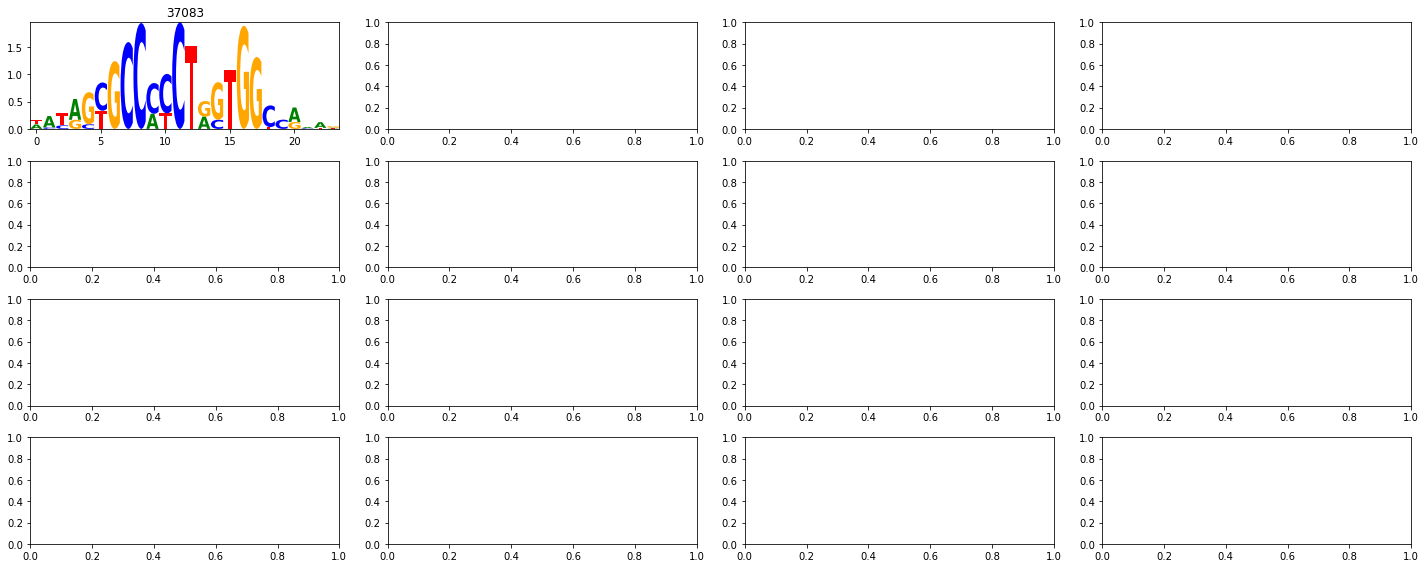

In [67]:
fig, axes = plt.subplots(4, 4, figsize=(20,8), tight_layout=True)
for i, (pfm, ax) in enumerate(zip(pfms, axes.ravel())):
    ppm = pfm/pfm.sum(axis=1, keepdims=True)
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"])
    ic = ppm.applymap(get_information_content)
    logomaker.Logo(ic, ax=ax)
    ax.set_title(Ns[i])